In [130]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

In [3]:
ls

Dialogue-Act-Reconizor/                opensmile/
classification.ipynb                   opensmile_feature_extract.sh
feature_extraction_and_analysis.ipynb  opensmile_feature_norm.csv
hw3_features.csv                       opensmile_features.csv
hw3_speech_files/


In [4]:
df = pd.read_csv("opensmile_features.csv", delimiter=";")
df

,name,frameTime,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,...,F0_sma_de_range,F0_sma_de_maxPos,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis
0,'./hw3_speech_files/cc_001_anxiety_910.77_May-...,0.0,0.019556,0.000098,0.019459,28,0,0.005757,-0.000034,0.007680,...,132.02450,68,72,-5.437617e-08,-0.009950,0.562178,239.2275,15.470450,-1.312268e-02,11.23654
1,'./hw3_speech_files/cc_001_anxiety_916.11_Eigh...,0.0,0.020914,0.000058,0.020856,63,0,0.006449,-0.000096,0.012574,...,243.30440,34,38,-1.862645e-08,-0.012806,0.813158,710.0782,26.651490,1.785000e-02,12.79744
2,'./hw3_speech_files/cc_001_anxiety_918.66_Eigh...,0.0,0.027904,0.000117,0.027787,88,128,0.007473,-0.000076,0.012335,...,0.00000,0,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000
3,'./hw3_speech_files/cc_001_anxiety_928.48_Four...,0.0,0.052467,0.000205,0.052262,40,109,0.015300,-0.000016,0.016177,...,187.57450,21,24,0.000000e+00,-0.008456,0.460871,328.6690,18.131220,2.774320e-17,20.26844
4,'./hw3_speech_files/cc_001_anxiety_934.73_Nine...,0.0,0.074559,0.000146,0.074414,107,139,0.016310,0.000079,0.010823,...,81.43034,9,17,1.362392e-08,-0.005247,0.364690,67.0573,8.191598,8.360357e-01,19.55287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,'./hw3_speech_files/mm_001_shame_2878.13_six-h...,0.0,0.061485,0.000223,0.061262,38,182,0.006357,-0.000095,0.015010,...,0.00000,0,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000
2320,'./hw3_speech_files/mm_001_shame_2883.75_six-h...,0.0,0.086048,0.000306,0.085741,33,0,0.010353,-0.000197,0.023471,...,0.00000,0,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000
2321,'./hw3_speech_files/mm_001_shame_2889.69_ten-t...,0.0,0.080753,0.000240,0.080512,66,0,0.007846,-0.000027,0.010297,...,0.00000,0,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000
2322,'./hw3_speech_files/mm_001_shame_2895.38_ten-t...,0.0,0.136426,0.000210,0.136216,46,133,0.011356,-0.000083,0.017353,...,0.00000,0,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000


In [5]:
df["emotion"] = df.apply(lambda x: x["name"].split("/")[2].split("_")[2], axis=1)
df["speaker"] = df.apply(lambda x: x["name"].split("/")[2].split("_")[0], axis=1)
df.drop(columns=["name"], inplace=True)
df

,frameTime,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,pcm_RMSenergy_sma_linregerrQ,...,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis,emotion,speaker
0,0.0,0.019556,0.000098,0.019459,28,0,0.005757,-0.000034,0.007680,0.000014,...,72,-5.437617e-08,-0.009950,0.562178,239.2275,15.470450,-1.312268e-02,11.23654,anxiety,cc
1,0.0,0.020914,0.000058,0.020856,63,0,0.006449,-0.000096,0.012574,0.000024,...,38,-1.862645e-08,-0.012806,0.813158,710.0782,26.651490,1.785000e-02,12.79744,anxiety,cc
2,0.0,0.027904,0.000117,0.027787,88,128,0.007473,-0.000076,0.012335,0.000039,...,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000,anxiety,cc
3,0.0,0.052467,0.000205,0.052262,40,109,0.015300,-0.000016,0.016177,0.000199,...,24,0.000000e+00,-0.008456,0.460871,328.6690,18.131220,2.774320e-17,20.26844,anxiety,cc
4,0.0,0.074559,0.000146,0.074414,107,139,0.016310,0.000079,0.010823,0.000423,...,17,1.362392e-08,-0.005247,0.364690,67.0573,8.191598,8.360357e-01,19.55287,anxiety,cc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,0.0,0.061485,0.000223,0.061262,38,182,0.006357,-0.000095,0.015010,0.000092,...,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000,shame,mm
2320,0.0,0.086048,0.000306,0.085741,33,0,0.010353,-0.000197,0.023471,0.000252,...,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000,shame,mm
2321,0.0,0.080753,0.000240,0.080512,66,0,0.007846,-0.000027,0.010297,0.000171,...,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000,shame,mm
2322,0.0,0.136426,0.000210,0.136216,46,133,0.011356,-0.000083,0.017353,0.000456,...,0,0.000000e+00,0.000000,0.000000,0.0000,0.000000,0.000000e+00,0.00000,shame,mm


In [6]:
# This takes a while, please go ahead to the next cell to get the prepared data
df_norm = copy.deepcopy(df)
for feature in tqdm(df_norm.columns[:-2]):
    df_norm[feature] = df_norm.apply(lambda x: x[feature] \
                           - df_norm[(df_norm.emotion=="neutral") & (df_norm.speaker == x["speaker"])][feature].mean(), axis=1)
# save df_norm
df_norm.to_csv("opensmile_feature_norm.csv")
df_norm.head()

  1%|▌                                          | 5/385 [00:06<08:27,  1.34s/it]


KeyboardInterrupt: 

In [3]:
df_data = pd.read_csv("opensmile_feature_norm.csv", index_col=0)
df_data

,frameTime,pcm_RMSenergy_sma_max,pcm_RMSenergy_sma_min,pcm_RMSenergy_sma_range,pcm_RMSenergy_sma_maxPos,pcm_RMSenergy_sma_minPos,pcm_RMSenergy_sma_amean,pcm_RMSenergy_sma_linregc1,pcm_RMSenergy_sma_linregc2,pcm_RMSenergy_sma_linregerrQ,...,F0_sma_de_minPos,F0_sma_de_amean,F0_sma_de_linregc1,F0_sma_de_linregc2,F0_sma_de_linregerrQ,F0_sma_de_stddev,F0_sma_de_skewness,F0_sma_de_kurtosis,emotion,speaker
0,0.0,0.003265,0.000033,0.003232,-8.722222,-7.500000,0.001084,-0.000003,0.001466,-0.000007,...,67.333333,-5.480003e-08,-0.009446,0.530899,221.605911,14.480850,-0.016219,10.599866,anxiety,cc
1,0.0,0.004623,-0.000006,0.004629,26.277778,-7.500000,0.001777,-0.000065,0.006360,0.000002,...,33.333333,-1.905031e-08,-0.012301,0.781879,692.456611,25.661890,0.014754,12.160766,anxiety,cc
2,0.0,0.011612,0.000052,0.011560,51.277778,120.500000,0.002801,-0.000045,0.006121,0.000018,...,-4.666667,-4.238553e-10,0.000504,-0.031279,-17.621589,-0.989600,-0.003096,-0.636674,anxiety,cc
3,0.0,0.036175,0.000141,0.036035,3.277778,101.500000,0.010627,0.000015,0.009962,0.000178,...,19.333333,-4.238553e-10,-0.007952,0.429592,311.047411,17.141620,-0.003096,19.631766,anxiety,cc
4,0.0,0.058268,0.000081,0.058187,70.277778,131.500000,0.011638,0.000110,0.004609,0.000402,...,12.333333,1.320006e-08,-0.004743,0.333411,49.435711,7.201998,0.832939,18.916196,anxiety,cc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,0.0,0.011365,-0.000332,0.011697,-12.777778,81.111111,-0.004851,-0.000057,0.002048,-0.000042,...,-26.555556,2.987066e-08,0.056889,-3.135208,-547.734967,-22.967177,-0.191359,-5.608791,shame,mm
2320,0.0,0.035927,-0.000248,0.036176,-17.777778,-100.888889,-0.000856,-0.000159,0.010509,0.000118,...,-26.555556,2.987066e-08,0.056889,-3.135208,-547.734967,-22.967177,-0.191359,-5.608791,shame,mm
2321,0.0,0.030632,-0.000314,0.030947,15.222222,-100.888889,-0.003362,0.000011,-0.002665,0.000038,...,-26.555556,2.987066e-08,0.056889,-3.135208,-547.734967,-22.967177,-0.191359,-5.608791,shame,mm
2322,0.0,0.086305,-0.000345,0.086650,-4.777778,32.111111,0.000148,-0.000045,0.004391,0.000323,...,-26.555556,2.987066e-08,0.056889,-3.135208,-547.734967,-22.967177,-0.191359,-5.608791,shame,mm


In [12]:
# for feature in df_data.columns[:-2]:
#     print(f"Feature: {feature}")
#     # order = df_data.groupby("emotion")[feature].mean().sort_values().index
#     order_norm = df_data.groupby("emotion")[feature].mean().sort_values().index
# #     plt.figure(figsize=(15,8))
# #     plt.grid("on")
# #     plt.title("Without Normalization")
# #     sns.boxplot(data=df, x=df.emotion, y=df[feature], order=order)
#     plt.figure(figsize=(15,8))
#     plt.grid("on")
#     plt.title("With Normalization")
#     sns.boxplot(data=df_data, x=df_data.emotion, y=df_data[feature], order=order_norm)
#     plt.show()

In [10]:
speakers = set(df_data["speaker"].values)
speakers

{'cc', 'cl', 'gg', 'jg', 'mf', 'mk', 'mm'}

In [160]:
def plot_confusion_matrix(img_path, index, y_test, y_pred, categories):
    # confusion matrix
    plt.rc('font', size=10)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0], display_labels=categories)
    axs[0].set_title("Confusion matrix")
    axs[0].tick_params(axis='x', rotation=45)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[1],
                                            normalize="true", values_format=".0%",
                                           display_labels=categories)
    axs[1].set_title("CM normalized by row")
    axs[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(img_path/f"confusion_matrix_{index+1}.png", format="png", dpi=300)
    plt.show()

    # error matrix
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
    plt.rc('font', size=10)
    weight = (y_pred != y_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[0],
                                            sample_weight=weight,
                                            normalize="true", values_format=".0%",
                                           display_labels=categories)
    axs[0].set_title("Errors normalized by row")
    axs[0].tick_params(axis='x', rotation=45)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[1],
                                            sample_weight=weight,
                                            normalize="pred", values_format=".0%",
                                           display_labels=categories)
    axs[1].set_title("Errors normalized by column")
    axs[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(img_path/f"confusion_error_{index+1}.png", format="png", dpi=300)
    plt.xticks(rotation = 45)
    plt.show()

In [162]:
def leave_one_out_test(X, y, groups, model, norm="standard", get_conf_mtx=False):
    logo = LeaveOneGroupOut()
    ord_enc = OrdinalEncoder()
    y_enc = ord_enc.fit_transform(y.reshape(-1,1)).flatten()
    accs = []
    f1_weights = []
    f1_macros = []
    
    IMAGES_PATH = Path() / "plots"
    IMAGES_PATH.mkdir(parents=True, exist_ok=True)
    
    for i, (train_index, test_index) in enumerate(logo.split(X, y_enc, groups)):
        print(f"{i+1}) Test Speaker: {set(df_data.iloc[test_index,:].speaker.values)} | Train Speakers: {set(df_data.iloc[train_index,:].speaker.values)} ")
        assert len(test_index) == np.sum(df_data.speaker==df_data.iloc[test_index[0],:].speaker)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_enc[train_index], y_enc[test_index]
        if norm == "standard":
            std_sc = StandardScaler()
            X_train = std_sc.fit_transform(X_train)
            X_test = std_sc.transform(X_test)
        elif norm == "minmax":
            mm_sc = MinMaxScaler()
            X_train = mm_sc.fit_transform(X_train)
            X_test = mm_sc.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1_weighted = f1_score(y_test, y_pred, average="weighted")
        f1_macro = f1_score(y_test, y_pred, average="macro")
        
        print(classification_report(y_test, y_pred, target_names=ord_enc.categories_[0]))
        accs.append(acc*len(y_pred))
        f1_weights.append(f1_weighted*len(y_pred))
        f1_macros.append(f1_macro*len(y_pred))
        
        if get_conf_mtx:
            plot_confusion_matrix(IMAGES_PATH, i, y_test, y_pred, ord_enc.categories_[0])
        
    print(f"MODEL: {model}")

    agg_acc = np.sum(accs) / len(y)
    agg_f1_w = np.sum(f1_weights) / len(y)
    agg_f1_m = np.sum(f1_macros) / len(y)
    
    print(f"Aggregated Average Accuracy: {agg_acc}\nAggregated Average F1-Score(weighted): {agg_f1_w}\nAggregated Average F1-Score(macro): {agg_f1_m}")
    return agg_acc, agg_f1_w, agg_f1_m, accs, f1_weights, f1_macros



In [113]:
X, y = df_data.iloc[:, :-2].values, df_data.iloc[:, -2].values
groups = df_data.iloc[:, -1].values

In [114]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_res = leave_one_out_test(X, y, groups, rnd_clf)

1) Test Speaker: {'cc'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'mf'} 
              precision    recall  f1-score   support

     anxiety       0.03      0.10      0.05        10
     boredom       0.00      0.00      0.00        15
  cold-anger       0.07      0.07      0.07        15
    contempt       0.15      0.14      0.14        22
     despair       0.10      0.22      0.14         9
     disgust       0.12      0.03      0.05        31
     elation       0.24      0.50      0.33        16
       happy       0.19      0.22      0.20        23
   hot-anger       0.33      0.93      0.49        14
    interest       0.00      0.00      0.00        17
     neutral       0.74      0.94      0.83        18
       panic       0.27      0.22      0.24        18
       pride       0.25      0.13      0.17        23
     sadness       0.40      0.15      0.22        13
       shame       1.00      0.05      0.09        21

    accuracy                           0.23       265


In [115]:
# models: sklearn's RandomForestClassifier, XGboost, MLP, LightGBM
xgb_clf = XGBClassifier()
xgb_res = leave_one_out_test(X, y, groups, xgb_clf)

1) Test Speaker: {'cc'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'mf'} 
              precision    recall  f1-score   support

     anxiety       0.05      0.10      0.07        10
     boredom       0.00      0.00      0.00        15
  cold-anger       0.00      0.00      0.00        15
    contempt       0.20      0.09      0.13        22
     despair       0.07      0.22      0.11         9
     disgust       0.32      0.19      0.24        31
     elation       0.11      0.19      0.14        16
       happy       0.18      0.26      0.21        23
   hot-anger       0.28      0.79      0.41        14
    interest       0.38      0.35      0.36        17
     neutral       0.67      0.78      0.72        18
       panic       0.31      0.22      0.26        18
       pride       0.42      0.22      0.29        23
     sadness       0.24      0.31      0.27        13
       shame       0.00      0.00      0.00        21

    accuracy                           0.24       265


/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.38      0.30      0.33        30
     boredom       0.33      0.07      0.11        30
  cold-anger       0.00      0.00      0.00        27
    contempt       0.43      0.38      0.41        26
     despair       0.07      0.04      0.05        28
     disgust       0.41      0.25      0.31        51
     elation       0.20      0.46      0.28        28
       happy       0.19      0.50      0.28        30
   hot-anger       0.14      0.05      0.07        22
    interest       0.19      0.10      0.13        30
     neutral       0.38      0.89      0.53         9
       panic       0.15      0.33      0.21        27
       pride       0.13      0.08      0.10        25
     sadness       0.00      0.00      0.00        33
       shame       0.21      0.33      0.25        24

    accuracy                           0.22       420
   macro avg       0.21      0.25      0.20       420
weighted avg       0.22   

/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
xgb_clf = XGBClassifier(n_estimators=1000, colsample_bytree=0.5) #, eta=0.05, subsample=0.5, colsample_bytree=0.5)
xgb_res = leave_one_out_test(X, y, groups, xgb_clf)

1) Test Speaker: {'cc'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'mf'} 
              precision    recall  f1-score   support

     anxiety       0.05      0.10      0.07        10
     boredom       0.00      0.00      0.00        15
  cold-anger       0.17      0.07      0.10        15
    contempt       0.56      0.23      0.32        22
     despair       0.10      0.33      0.15         9
     disgust       0.33      0.13      0.19        31
     elation       0.12      0.19      0.15        16
       happy       0.22      0.43      0.29        23
   hot-anger       0.27      0.57      0.36        14
    interest       0.39      0.41      0.40        17
     neutral       0.73      0.89      0.80        18
       panic       0.24      0.22      0.23        18
       pride       0.15      0.09      0.11        23
     sadness       0.29      0.31      0.30        13
       shame       0.00      0.00      0.00        21

    accuracy                           0.26       265


/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.00      0.00      0.00        21
     boredom       0.38      0.21      0.27        29
  cold-anger       0.40      0.15      0.22        27
    contempt       0.22      0.28      0.25        25
     despair       0.00      0.00      0.00        29
     disgust       0.13      0.36      0.19        22
     elation       0.16      0.30      0.21        27
       happy       0.31      0.19      0.24        21
   hot-anger       0.41      0.35      0.38        26
    interest       0.40      0.46      0.43        26
     neutral       0.23      0.94      0.36        17
       panic       1.00      0.05      0.09        21
       pride       0.18      0.12      0.15        24
     sadness       0.33      0.44      0.38        27
       shame       0.00      0.00      0.00        26

    accuracy                           0.24       368
   macro avg       0.28      0.26      0.21       368
weighted avg       0.27   

/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.16      0.10      0.12        29
     boredom       0.33      0.05      0.09        20
  cold-anger       0.25      0.22      0.23        23
    contempt       0.00      0.00      0.00        21
     despair       0.17      0.17      0.17        53
     disgust       0.05      0.24      0.09        21
     elation       0.17      0.04      0.07        23
       happy       0.50      0.07      0.12        42
   hot-anger       0.23      0.50      0.32        22
    interest       0.22      0.30      0.25        44
     neutral       0.50      1.00      0.67         8
       panic       0.00      0.00      0.00        21
       pride       0.14      0.17      0.16        23
     sadness       0.00      0.00      0.00        22
       shame       0.28      0.40      0.33        25

    accuracy                           0.18       397
   macro avg       0.20      0.22      0.17       397
weighted avg       0.20   

In [120]:
svc = SVC()
svc_res = leave_one_out_test(X, y, groups, svc)

1) Test Speaker: {'cc'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'mf'} 


/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.08      0.10      0.09        10
     boredom       0.00      0.00      0.00        15
  cold-anger       0.00      0.00      0.00        15
    contempt       0.20      0.23      0.21        22
     despair       0.11      0.44      0.18         9
     disgust       0.00      0.00      0.00        31
     elation       0.24      0.50      0.32        16
       happy       0.09      0.13      0.11        23
   hot-anger       0.37      0.79      0.50        14
    interest       0.09      0.12      0.10        17
     neutral       0.81      0.94      0.87        18
       panic       0.24      0.22      0.23        18
       pride       0.00      0.00      0.00        23
     sadness       0.00      0.00      0.00        13
       shame       0.00      0.00      0.00        21

    accuracy                           0.21       265
   macro avg       0.15      0.23      0.17       265
weighted avg       0.14   

/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.17      0.16      0.16        19
     boredom       0.09      0.64      0.17        14
  cold-anger       0.00      0.00      0.00        22
    contempt       0.33      0.09      0.14        23
     despair       0.00      0.00      0.00        21
     disgust       0.24      0.35      0.28        23
     elation       0.25      0.05      0.08        20
       happy       0.00      0.00      0.00        20
   hot-anger       0.40      0.11      0.17        18
    interest       0.00      0.00      0.00        19
     neutral       0.89      1.00      0.94         8
       panic       0.00      0.00      0.00        14
       pride       0.12      0.44      0.18        18
     sadness       0.00      0.00      0.00        19
       shame       0.08      0.07      0.07        15

    accuracy                           0.15       273
   macro avg       0.17      0.19      0.15       273
weighted avg       0.15   

/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.18      0.10      0.13        29
     boredom       0.07      0.05      0.06        20
  cold-anger       0.17      0.17      0.17        23
    contempt       0.11      0.10      0.10        21
     despair       0.25      0.34      0.29        53
     disgust       0.09      0.29      0.14        21
     elation       0.50      0.35      0.41        23
       happy       0.12      0.02      0.04        42
   hot-anger       0.09      0.09      0.09        22
    interest       0.31      0.36      0.33        44
     neutral       0.73      1.00      0.84         8
       panic       0.00      0.00      0.00        21
       pride       0.07      0.09      0.08        23
     sadness       0.11      0.18      0.14        22
       shame       0.14      0.08      0.10        25

    accuracy                           0.19       397
   macro avg       0.20      0.21      0.20       397
weighted avg       0.19   

In [ ]:
# ---

In [13]:
# feature selection
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier())

In [18]:
selected_feat= df_data.columns[:-2][(sel.get_support())]
len(selected_feat)

142

In [19]:
selected_feat

Index(['pcm_RMSenergy_sma_max', 'pcm_RMSenergy_sma_min',
       'pcm_RMSenergy_sma_range', 'pcm_RMSenergy_sma_amean',
       'pcm_RMSenergy_sma_linregerrQ', 'pcm_RMSenergy_sma_stddev',
       'pcm_RMSenergy_sma_kurtosis', 'pcm_fftMag_mfcc_sma[1]_max',
       'pcm_fftMag_mfcc_sma[1]_range', 'pcm_fftMag_mfcc_sma[1]_amean',
       ...
       'voiceProb_sma_de_linregc2', 'voiceProb_sma_de_linregerrQ',
       'voiceProb_sma_de_stddev', 'F0_sma_de_range', 'F0_sma_de_minPos',
       'F0_sma_de_linregc1', 'F0_sma_de_linregc2', 'F0_sma_de_linregerrQ',
       'F0_sma_de_stddev', 'F0_sma_de_kurtosis'],
      dtype='object', length=142)

In [23]:
X_sel = df_data[selected_feat].values

In [121]:
svc = SVC()
svc_res = leave_one_out_test(X_sel, y, groups, svc)

1) Test Speaker: {'cc'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'mf'} 
              precision    recall  f1-score   support

     anxiety       0.13      0.20      0.16        10
     boredom       0.00      0.00      0.00        15
  cold-anger       0.00      0.00      0.00        15
    contempt       0.23      0.14      0.17        22
     despair       0.09      0.33      0.14         9
     disgust       0.50      0.13      0.21        31
     elation       0.23      0.88      0.36        16
       happy       0.14      0.09      0.11        23
   hot-anger       0.40      0.71      0.51        14
    interest       0.07      0.12      0.09        17
     neutral       0.94      0.94      0.94        18
       panic       0.35      0.33      0.34        18
       pride       0.00      0.00      0.00        23
     sadness       0.29      0.15      0.20        13
       shame       0.50      0.05      0.09        21

    accuracy                           0.25       265


/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.18      0.11      0.13        19
     boredom       0.12      0.71      0.20        14
  cold-anger       0.00      0.00      0.00        22
    contempt       0.20      0.04      0.07        23
     despair       0.00      0.00      0.00        21
     disgust       0.37      0.61      0.46        23
     elation       0.20      0.05      0.08        20
       happy       0.00      0.00      0.00        20
   hot-anger       0.50      0.22      0.31        18
    interest       0.00      0.00      0.00        19
     neutral       0.80      1.00      0.89         8
       panic       0.00      0.00      0.00        14
       pride       0.08      0.33      0.13        18
     sadness       0.00      0.00      0.00        19
       shame       0.14      0.13      0.14        15

    accuracy                           0.18       273
   macro avg       0.17      0.21      0.16       273
weighted avg       0.15   

In [126]:
gammas = [0.005, 0.006]
best_acc, best_f1_w, best_f1_m = 0, 0, 0
best_gamma_acc = None
best_gamma_f1_w = None
best_gamma_f1_m = None

for gamma in gammas:
    svc = SVC(kernel='rbf', gamma=gamma)
    svc_res = leave_one_out_test(X_sel, y, groups, svc)
    if svc_res[0] > best_acc:
        best_acc = svc_res[0]
        best_gamma_acc = gamma
    if svc_res[1] > best_f1_w:
        best_f1_w = svc_res[1]
        best_gamma_f1_w = gamma
    if svc_res[2] > best_f1_m:
        best_f1_m = svc_res[2]
        best_gamma_f1_m = gamma
    print(gamma)
    print("="*50)
print(best_acc, best_gamma_acc)
print(best_f1_w, best_gamma_f1_w)
print(best_f1_m, best_gamma_f1_m)

1) Test Speaker: {'cc'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'mf'} 


/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.10      0.20      0.13        10
     boredom       0.00      0.00      0.00        15
  cold-anger       0.00      0.00      0.00        15
    contempt       0.25      0.14      0.18        22
     despair       0.09      0.33      0.14         9
     disgust       0.45      0.16      0.24        31
     elation       0.25      0.88      0.39        16
       happy       0.20      0.13      0.16        23
   hot-anger       0.38      0.71      0.50        14
    interest       0.07      0.12      0.09        17
     neutral       0.94      0.94      0.94        18
       panic       0.44      0.39      0.41        18
       pride       0.14      0.04      0.07        23
     sadness       0.29      0.15      0.20        13
       shame       0.00      0.00      0.00        21

    accuracy                           0.26       265
   macro avg       0.24      0.28      0.23       265
weighted avg       0.26   

/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.23      0.16      0.19        19
     boredom       0.12      0.79      0.21        14
  cold-anger       0.00      0.00      0.00        22
    contempt       0.00      0.00      0.00        23
     despair       0.00      0.00      0.00        21
     disgust       0.38      0.52      0.44        23
     elation       0.25      0.05      0.08        20
       happy       0.00      0.00      0.00        20
   hot-anger       0.56      0.28      0.37        18
    interest       0.00      0.00      0.00        19
     neutral       0.73      1.00      0.84         8
       panic       0.00      0.00      0.00        14
       pride       0.10      0.44      0.17        18
     sadness       0.00      0.00      0.00        19
       shame       0.11      0.07      0.08        15

    accuracy                           0.18       273
   macro avg       0.17      0.22      0.16       273
weighted avg       0.14   

/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.04      0.03      0.04        29
     boredom       0.08      0.05      0.06        20
  cold-anger       0.09      0.09      0.09        23
    contempt       0.07      0.05      0.06        21
     despair       0.20      0.25      0.22        53
     disgust       0.08      0.29      0.13        21
     elation       0.42      0.61      0.50        23
       happy       0.31      0.10      0.15        42
   hot-anger       0.18      0.09      0.12        22
    interest       0.27      0.25      0.26        44
     neutral       1.00      1.00      1.00         8
       panic       0.00      0.00      0.00        21
       pride       0.08      0.04      0.06        23
     sadness       0.14      0.27      0.19        22
       shame       0.13      0.12      0.12        25

    accuracy                           0.18       397
   macro avg       0.21      0.22      0.20       397
weighted avg       0.18   

/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.27      0.16      0.20        19
     boredom       0.12      0.79      0.21        14
  cold-anger       0.00      0.00      0.00        22
    contempt       0.00      0.00      0.00        23
     despair       0.00      0.00      0.00        21
     disgust       0.38      0.57      0.46        23
     elation       0.25      0.05      0.08        20
       happy       0.00      0.00      0.00        20
   hot-anger       0.56      0.28      0.37        18
    interest       0.00      0.00      0.00        19
     neutral       0.73      1.00      0.84         8
       panic       0.00      0.00      0.00        14
       pride       0.08      0.33      0.13        18
     sadness       0.00      0.00      0.00        19
       shame       0.10      0.07      0.08        15

    accuracy                           0.18       273
   macro avg       0.17      0.22      0.16       273
weighted avg       0.14   

/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.07      0.07      0.07        29
     boredom       0.10      0.05      0.07        20
  cold-anger       0.08      0.09      0.08        23
    contempt       0.06      0.05      0.05        21
     despair       0.21      0.26      0.23        53
     disgust       0.09      0.29      0.13        21
     elation       0.42      0.61      0.50        23
       happy       0.29      0.10      0.14        42
   hot-anger       0.12      0.05      0.07        22
    interest       0.28      0.25      0.27        44
     neutral       1.00      1.00      1.00         8
       panic       0.00      0.00      0.00        21
       pride       0.08      0.04      0.06        23
     sadness       0.14      0.27      0.19        22
       shame       0.09      0.08      0.09        25

    accuracy                           0.18       397
   macro avg       0.20      0.21      0.20       397
weighted avg       0.18   

In [127]:
print(f"Aggregated Accuracy with SVC: {best_acc*100:.2f}%")
print(f"Aggregated F1 Score(weighted) with SVC: {best_f1_w*100:.2f}%")
print(f"Aggregated F1 Score(macro) with SVC: {best_f1_m*100:.2f}%")

Aggregated Accuracy with SVC: 24.31%
Aggregated F1 Score(weighted) with SVC: 21.17%
Aggregated F1 Score(macro) with SVC: 22.94%


3. Error analysis  (30 points)

- Analyze the errors made by your best performing leave-one-speaker-out experiment, i.e. the best results you got for one of the 7 speakers.
    * Which class(es) were easiest to predict? Why do you think they were easy? 
    - Which were the most difficult? Why do you think they were difficult?
    - Based on this analysis, what ideas do you have to further improve your classifier?

In [110]:
# best performing one
# Model: svm.SVC(gamma=0.005)
# Test Speaker: {'mf'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'cc'} 
#              precision    recall   f1-score   support
# accuracy                             0.29       299
# weighted avg     0.33      0.37      0.27       299

1) Test Speaker: {'cc'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'mf'} 


/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.10      0.20      0.13        10
     boredom       0.00      0.00      0.00        15
  cold-anger       0.00      0.00      0.00        15
    contempt       0.25      0.14      0.18        22
     despair       0.09      0.33      0.14         9
     disgust       0.45      0.16      0.24        31
     elation       0.25      0.88      0.39        16
       happy       0.20      0.13      0.16        23
   hot-anger       0.38      0.71      0.50        14
    interest       0.07      0.12      0.09        17
     neutral       0.94      0.94      0.94        18
       panic       0.44      0.39      0.41        18
       pride       0.14      0.04      0.07        23
     sadness       0.29      0.15      0.20        13
       shame       0.00      0.00      0.00        21

    accuracy                           0.26       265
   macro avg       0.24      0.28      0.23       265
weighted avg       0.26   

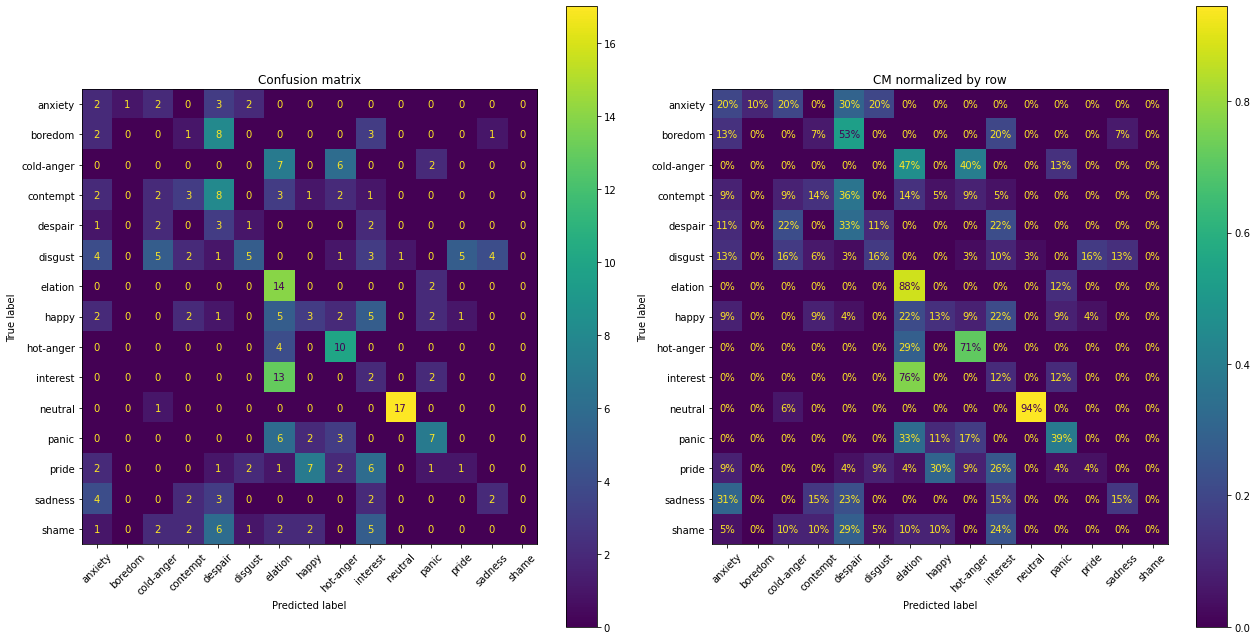

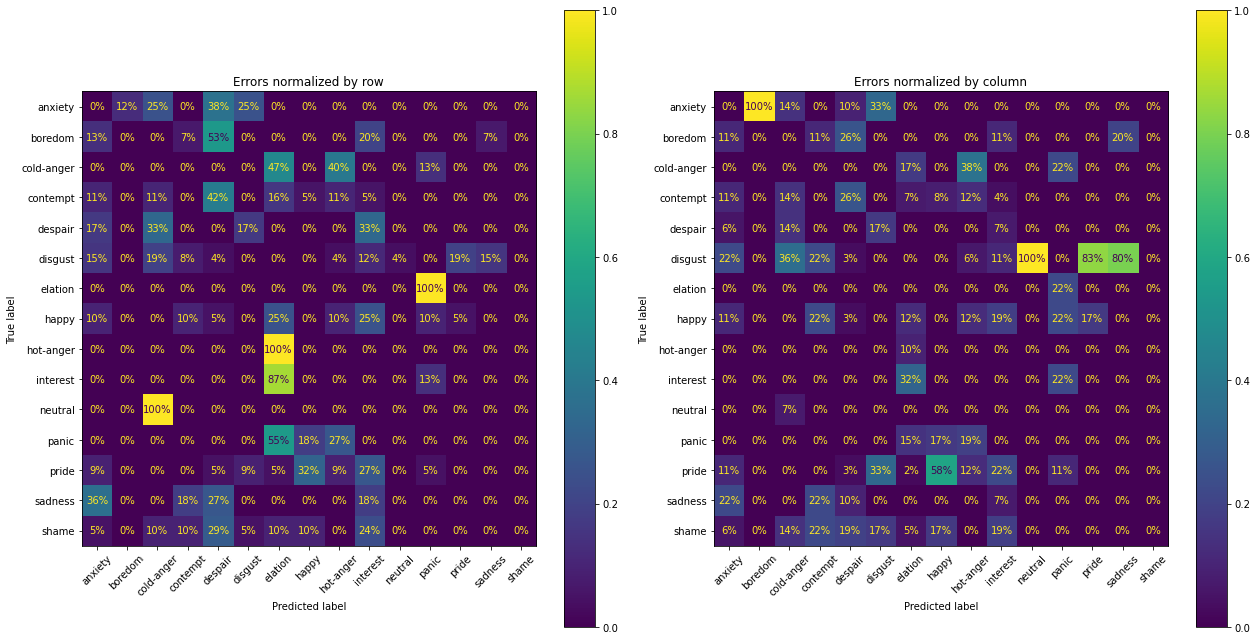

2) Test Speaker: {'cl'} | Train Speakers: {'mm', 'gg', 'jg', 'mk', 'cc', 'mf'} 
              precision    recall  f1-score   support

     anxiety       0.25      0.10      0.14        21
     boredom       0.24      0.55      0.34        29
  cold-anger       0.58      0.41      0.48        27
    contempt       0.00      0.00      0.00        25
     despair       0.00      0.00      0.00        29
     disgust       0.21      0.64      0.31        22
     elation       0.31      0.48      0.38        27
       happy       0.35      0.29      0.32        21
   hot-anger       0.48      0.38      0.43        26
    interest       0.26      0.38      0.31        26
     neutral       0.33      0.88      0.48        17
       panic       0.00      0.00      0.00        21
       pride       0.27      0.12      0.17        24
     sadness       0.38      0.19      0.25        27
       shame       0.12      0.04      0.06        26

    accuracy                           0.29       368


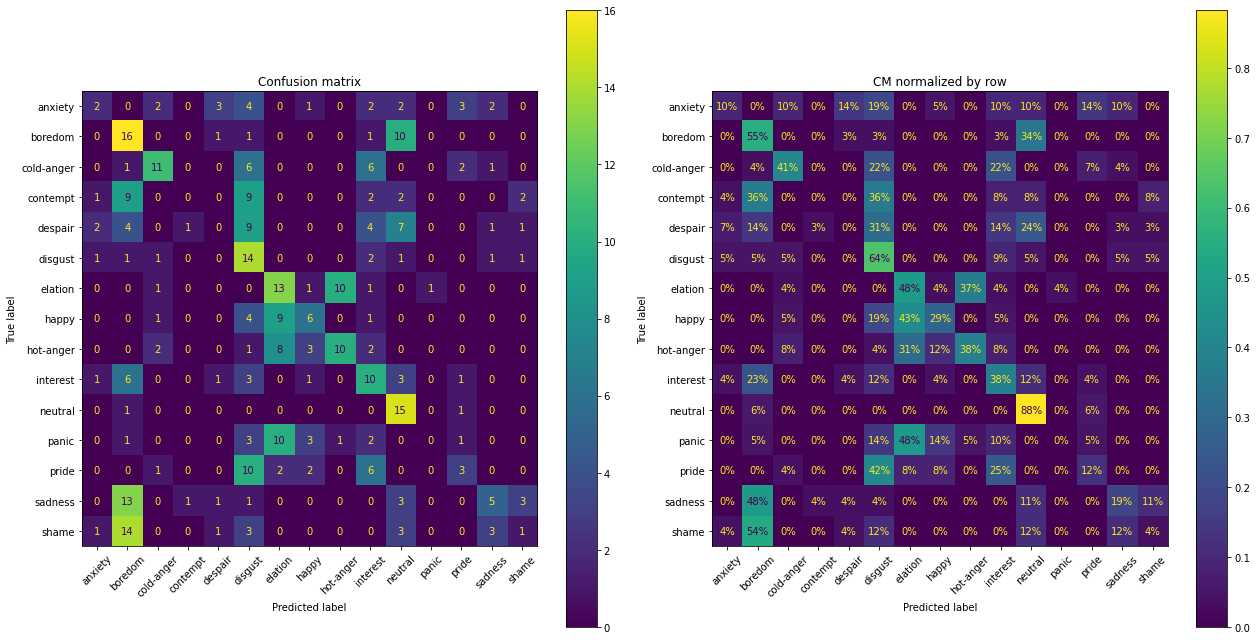

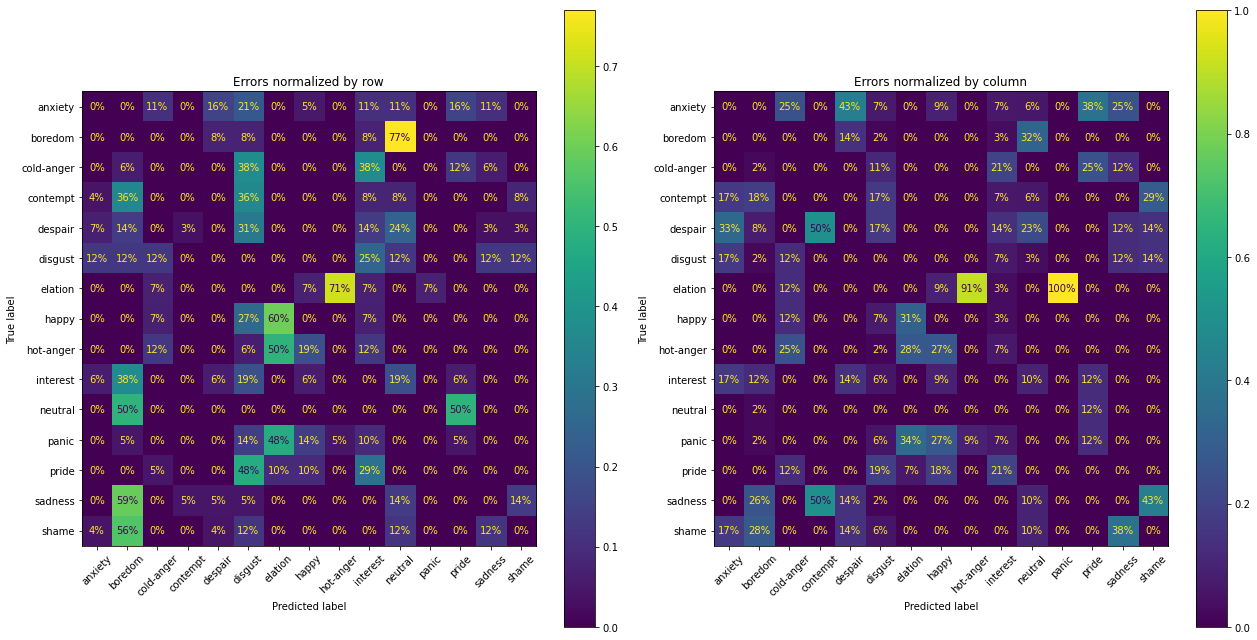

3) Test Speaker: {'gg'} | Train Speakers: {'cl', 'mm', 'jg', 'mk', 'cc', 'mf'} 
              precision    recall  f1-score   support

     anxiety       0.25      0.43      0.32        30
     boredom       0.67      0.07      0.12        30
  cold-anger       0.20      0.11      0.14        27
    contempt       0.37      0.27      0.31        26
     despair       0.11      0.04      0.05        28
     disgust       0.36      0.16      0.22        51
     elation       0.33      0.89      0.48        28
       happy       0.16      0.53      0.25        30
   hot-anger       0.23      0.23      0.23        22
    interest       0.50      0.03      0.06        30
     neutral       0.89      0.89      0.89         9
       panic       0.43      0.74      0.54        27
       pride       0.22      0.08      0.12        25
     sadness       0.00      0.00      0.00        33
       shame       0.29      0.29      0.29        24

    accuracy                           0.28       420


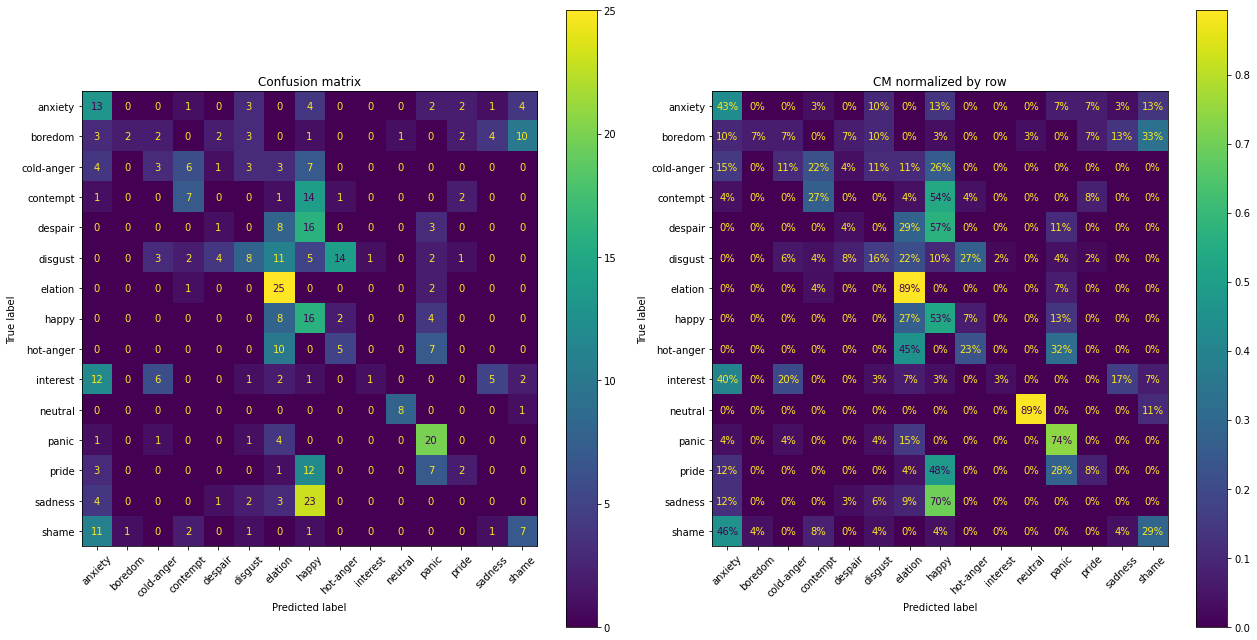

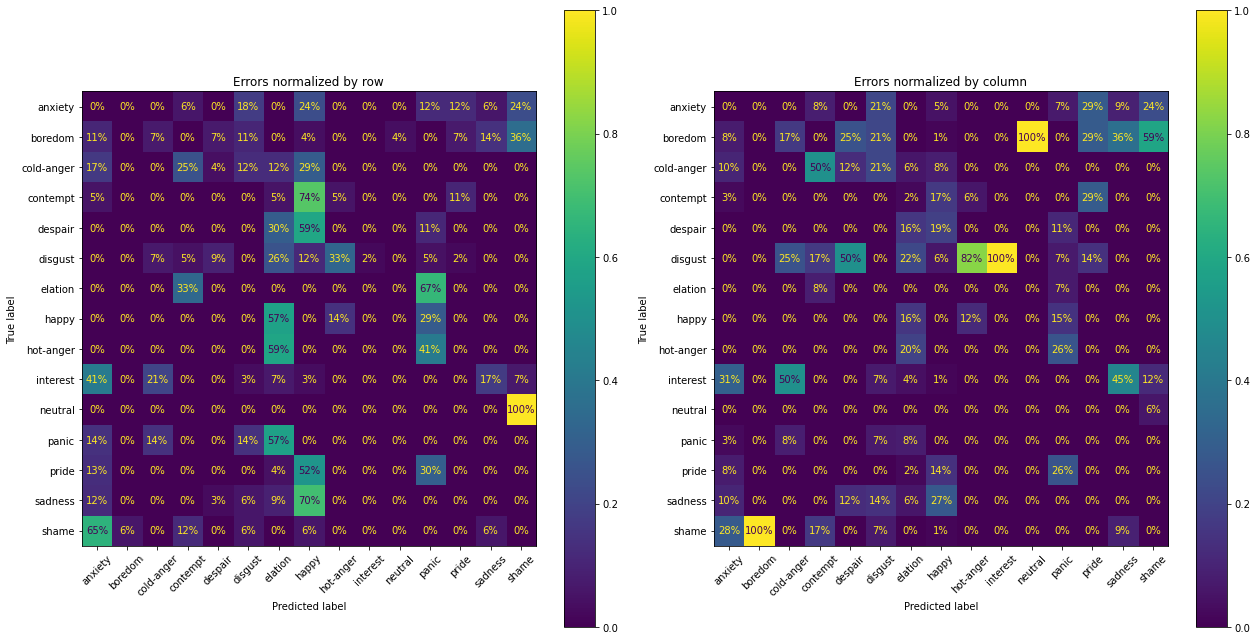

4) Test Speaker: {'jg'} | Train Speakers: {'cl', 'mm', 'gg', 'mk', 'cc', 'mf'} 


/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.23      0.16      0.19        19
     boredom       0.12      0.79      0.21        14
  cold-anger       0.00      0.00      0.00        22
    contempt       0.00      0.00      0.00        23
     despair       0.00      0.00      0.00        21
     disgust       0.38      0.52      0.44        23
     elation       0.25      0.05      0.08        20
       happy       0.00      0.00      0.00        20
   hot-anger       0.56      0.28      0.37        18
    interest       0.00      0.00      0.00        19
     neutral       0.73      1.00      0.84         8
       panic       0.00      0.00      0.00        14
       pride       0.10      0.44      0.17        18
     sadness       0.00      0.00      0.00        19
       shame       0.11      0.07      0.08        15

    accuracy                           0.18       273
   macro avg       0.17      0.22      0.16       273
weighted avg       0.14   

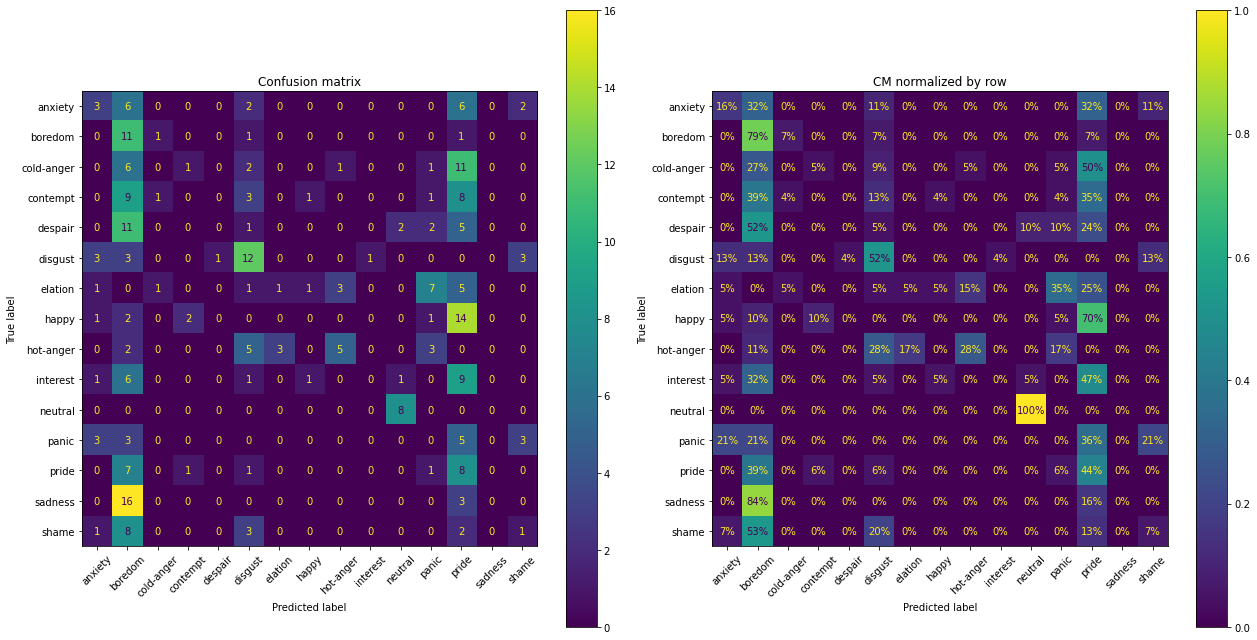

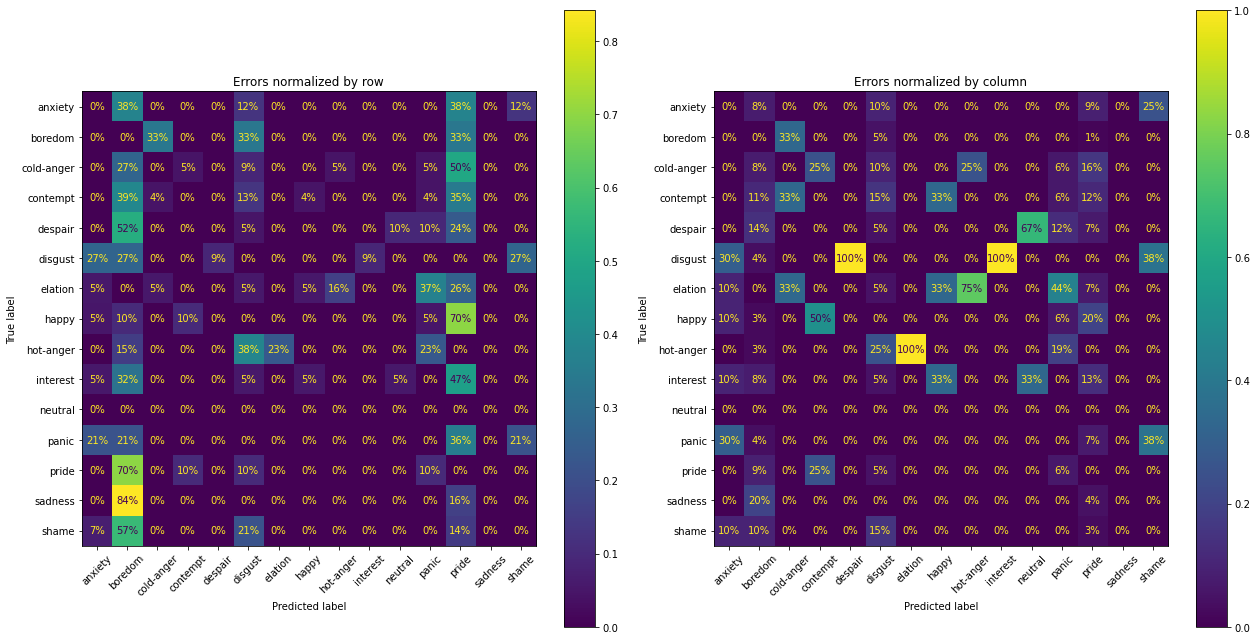

5) Test Speaker: {'mf'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'cc'} 
              precision    recall  f1-score   support

     anxiety       0.38      0.36      0.37        22
     boredom       0.35      0.52      0.42        27
  cold-anger       0.24      0.40      0.30        20
    contempt       0.57      0.30      0.39        44
     despair       0.00      0.00      0.00        16
     disgust       0.05      1.00      0.09         1
     elation       0.06      0.04      0.05        26
       happy       0.12      0.13      0.12        23
   hot-anger       0.34      0.48      0.40        21
    interest       0.15      0.37      0.22        19
     neutral       1.00      1.00      1.00        10
       panic       0.41      0.75      0.53        12
       pride       1.00      0.06      0.11        18
     sadness       0.50      0.05      0.09        20
       shame       0.29      0.10      0.15        20

    accuracy                           0.29       299


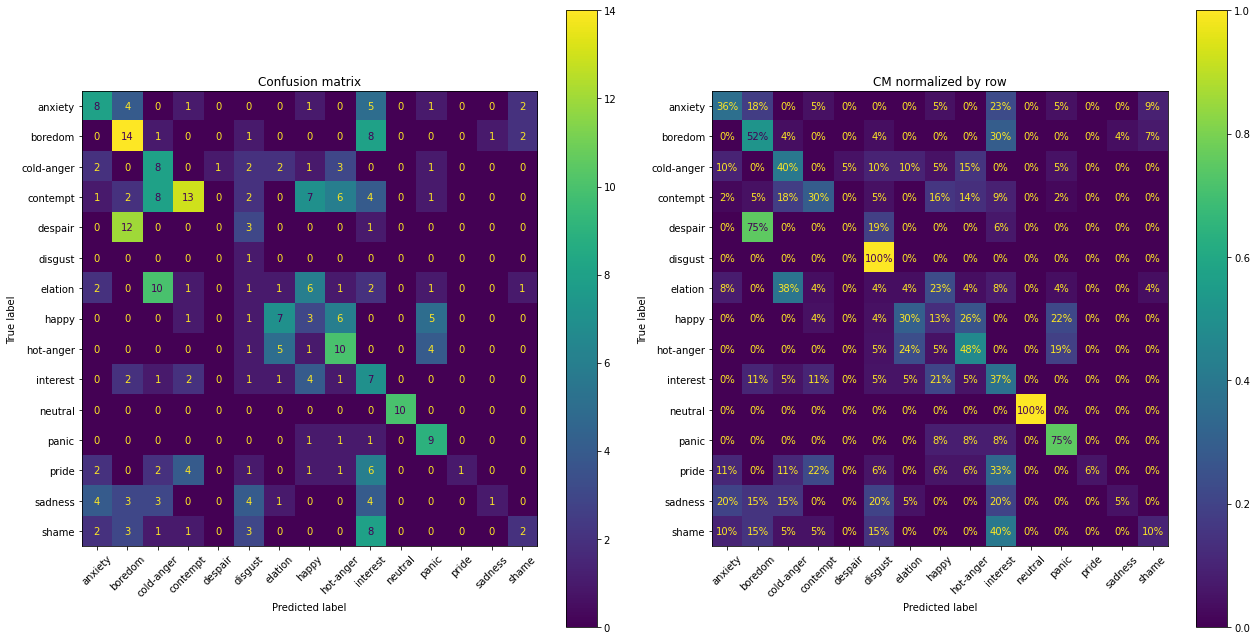

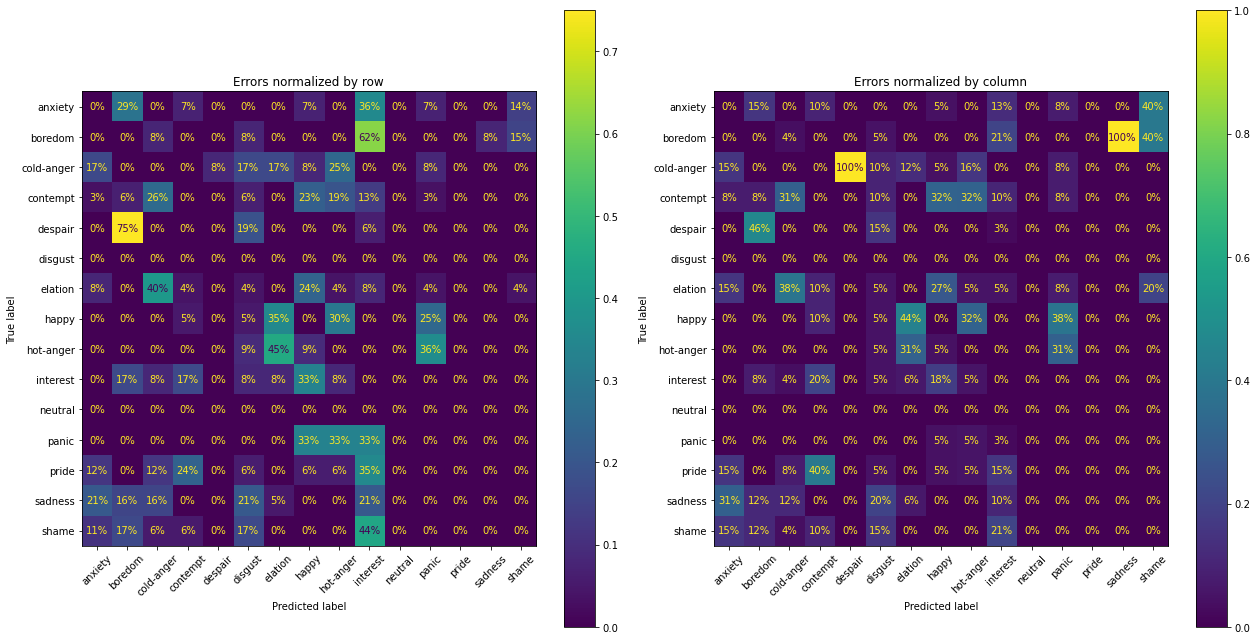

6) Test Speaker: {'mk'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'cc', 'mf'} 


/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gogorah/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     anxiety       0.04      0.03      0.04        29
     boredom       0.08      0.05      0.06        20
  cold-anger       0.09      0.09      0.09        23
    contempt       0.07      0.05      0.06        21
     despair       0.20      0.25      0.22        53
     disgust       0.08      0.29      0.13        21
     elation       0.42      0.61      0.50        23
       happy       0.31      0.10      0.15        42
   hot-anger       0.18      0.09      0.12        22
    interest       0.27      0.25      0.26        44
     neutral       1.00      1.00      1.00         8
       panic       0.00      0.00      0.00        21
       pride       0.08      0.04      0.06        23
     sadness       0.14      0.27      0.19        22
       shame       0.13      0.12      0.12        25

    accuracy                           0.18       397
   macro avg       0.21      0.22      0.20       397
weighted avg       0.18   

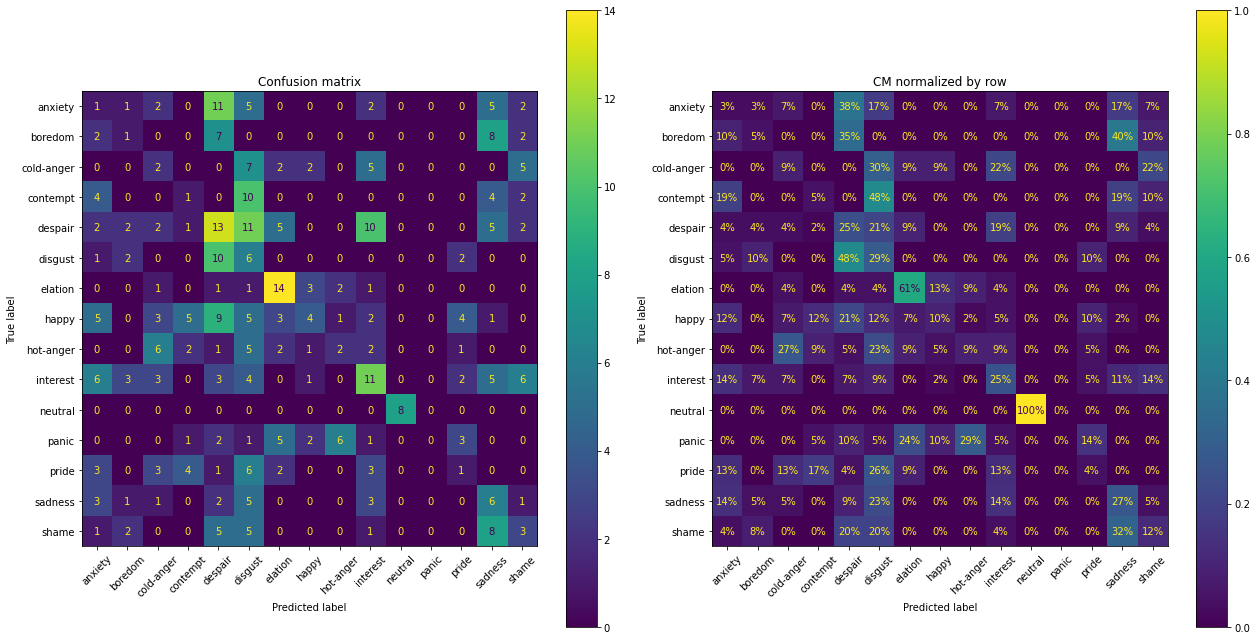

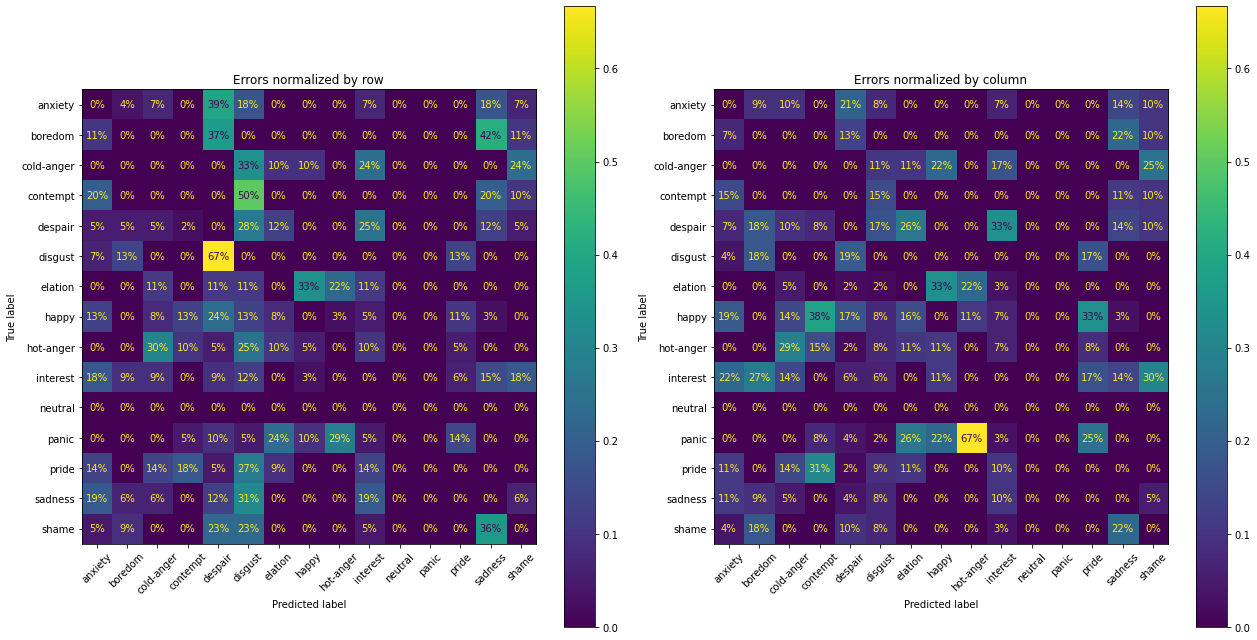

7) Test Speaker: {'mm'} | Train Speakers: {'cl', 'gg', 'jg', 'mk', 'cc', 'mf'} 
              precision    recall  f1-score   support

     anxiety       0.56      0.23      0.33        39
     boredom       0.21      0.53      0.30        19
  cold-anger       0.00      0.00      0.00        20
    contempt       0.11      0.42      0.17        19
     despair       0.08      0.17      0.11        18
     disgust       0.40      0.09      0.14        23
     elation       0.08      0.05      0.06        19
       happy       0.20      0.39      0.26        18
   hot-anger       1.00      0.06      0.12        16
    interest       0.33      0.05      0.08        21
     neutral       1.00      0.89      0.94         9
       panic       0.57      0.14      0.23        28
       pride       0.00      0.00      0.00        19
     sadness       0.09      0.18      0.12        17
       shame       0.28      0.29      0.29        17

    accuracy                           0.21       302


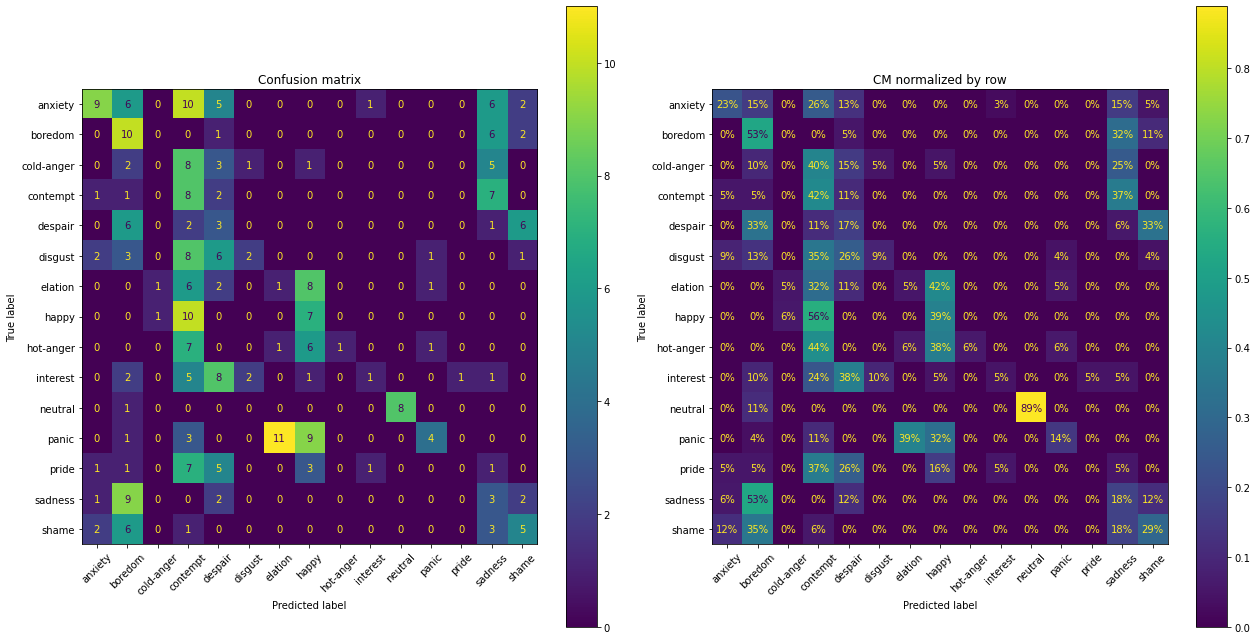

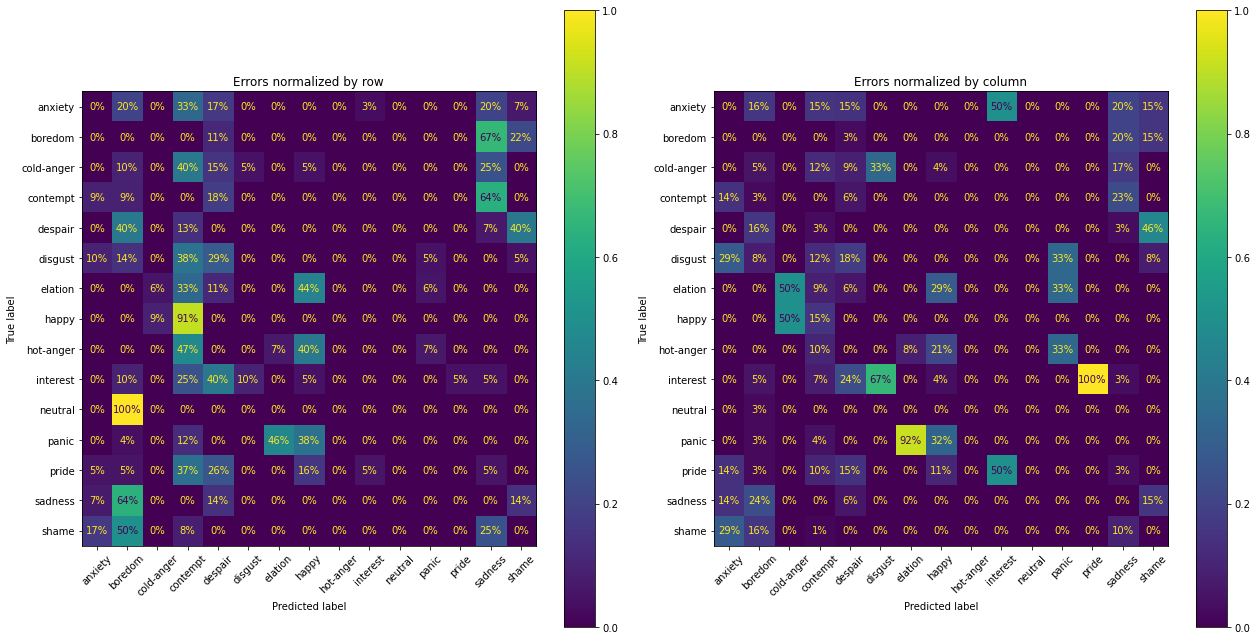

MODEL: SVC(gamma=0.005)
Aggregated Average Accuracy: 0.24311531841652323
Aggregated Average F1-Score(weighted): 0.21172854646889172
Aggregated Average F1-Score(macro): 0.22937300292714202


In [163]:
svc = SVC(kernel='rbf', gamma=0.005)
svc_res = leave_one_out_test(X_sel, y, groups, svc, get_conf_mtx=True)

---
## Analyze Errors of Best Performing Leave-One-Speaker-Out Experiment 
```
best performing one
Model: svm.SVC(gamma=0.005)
Test Speaker: {'mf'} | Train Speakers: {'cl', 'mm', 'gg', 'jg', 'mk', 'cc'} 
                precision    recall  f1-score   support

     anxiety       0.38      0.36      0.37        22
     boredom       0.35      0.52      0.42        27
  cold-anger       0.24      0.40      0.30        20
    contempt       0.57      0.30      0.39        44
     despair       0.00      0.00      0.00        16
     disgust       0.05      1.00      0.09         1
     elation       0.06      0.04      0.05        26
       happy       0.12      0.13      0.12        23
   hot-anger       0.34      0.48      0.40        21
    interest       0.15      0.37      0.22        19
     neutral       1.00      1.00      1.00        10
       panic       0.41      0.75      0.53        12
       pride       1.00      0.06      0.11        18
     sadness       0.50      0.05      0.09        20
       shame       0.29      0.10      0.15        20

    accuracy                           0.29       299
   macro avg       0.36      0.37      0.28       299
weighted avg       0.37      0.29      0.27       299
```
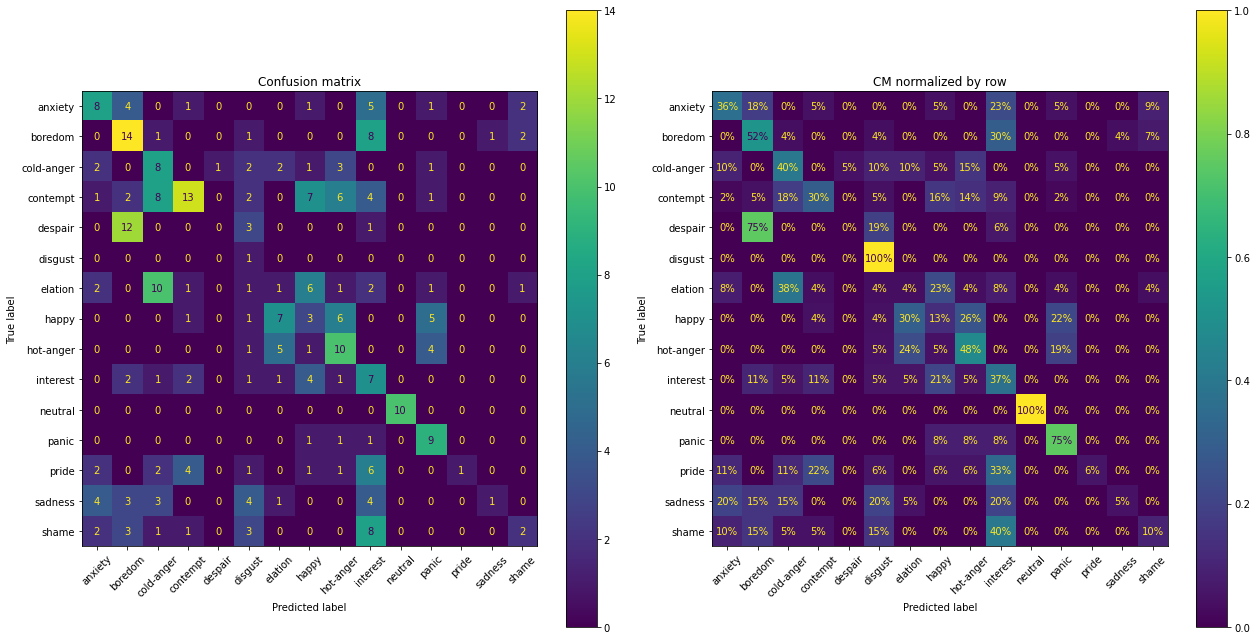
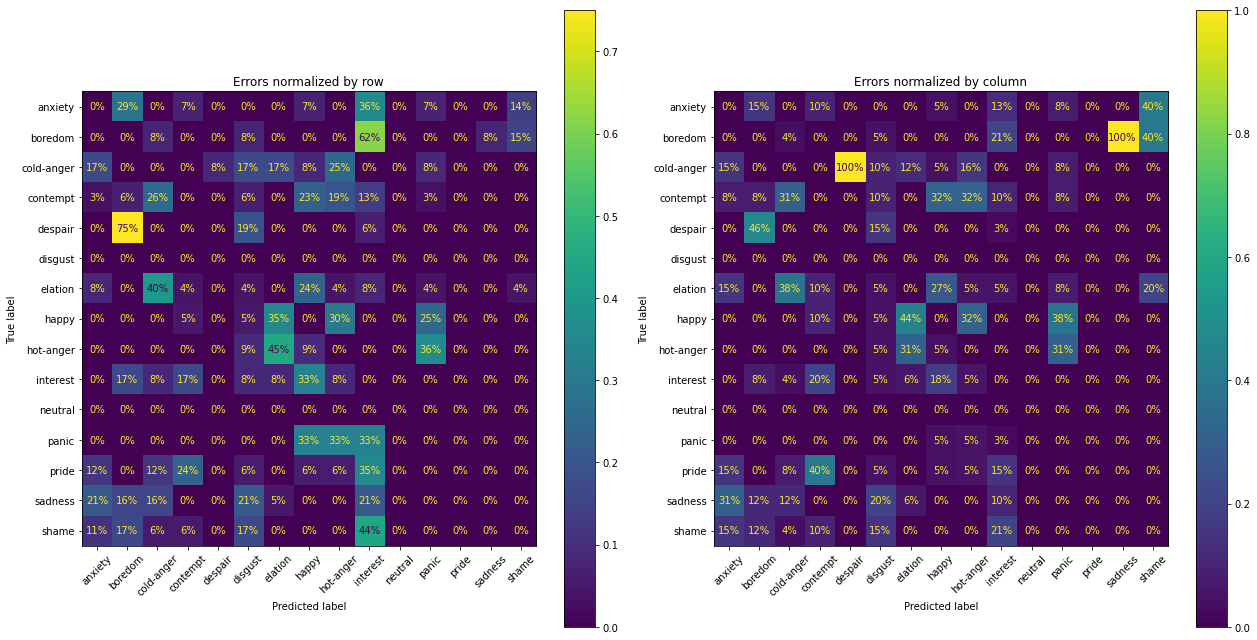

In [ ]:
### Which class(es) were easiest to predict? Why do you think they were easy?
Class with the highest f1-score was 'neutral', followed by 'panic', and 'boredom'. This would be because neutral speech segments are usually monotonal 
which would be easily distinguishable from other emotional voices. Also we can say that the neutral speeches of the 
speaker "mf" didn't made outlying data points that could have lied outside of the correct boundary
defined by the model trained with rest of the speakers' data. 
'boredom' would also be distinguishable from other emotional speeches in a similar sense, 
but have difference in features that made the model to seperate 'neutral' and 'boredom'
strong, aroused emotions would be reflected in the 'panic' speeches, making the model to relatively predict it well.
Furthermore, we can assume these emotions were easier to be conveyed by the participants; possibly participants 
had similar ideas on expressing these emotions in speech.
### Which were the most difficult? Why do you think they were difficult?
The hardest one was despair, followed elation, disgust, sadness, and pride. 12 out of 16 disgust segments were classified as 
boredom. It is possible that speaker mf's expression of despair had similar traits with the rest of the speakers' 
boredom. Possibly mf's expression of despair was low voiced or lacked power in speech. Speaker mf had only one disgust
segment, while it was correctly classified, some non-disgust segments were incorrectly predicted as disgust, making the
f1-score low for disgust. We can imagine that these emotions are hard to be expressed in
such a short segment of speech, and possibly people have larger variety in conveying these emotions in speech.
### Based on this analysis, what ideas do you have to further improve your classifier?
First, trying different methods of normalization would help. While normalizing based on the speaker's neutral speech
is a commonly used method, experimenting other normalization would help; possibly combine stardardization.
Second, feature selection process would improve the quality of this problem as noisy features may hinder the performance.
Moreover, we can try deleting outliers to make the data more general and use over- or under- sampling methods to
balance the datasets. Lastly, improving the quality and the size of the dataset would be very helpful. Some emotions
seem to be very difficult to express in such a short segment without any context; making a dataset by 
providing the participant with appropriate text contexts can be helpful while we would have to be careful in providing
these contexts as some texts may induce people to speak in a certain way, 
making the model trained based on this less general.

